<a href="https://colab.research.google.com/github/AryamanKaprekar/Practice_Collection/blob/main/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2.5.0+cu121
0.20.0+cu121
Using device: cuda


In [82]:
import requests
import kagglehub
import zipfile
from pathlib import Path
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print(f"Path to dataset",path)
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset
dataset_path = path # Replace with your actual path

# Define paths for training and test sets
train_path = "/content/train"
test_path = "/content/test"

# Create directories for training and testing sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Split each classification into training and test sets
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)

    # Skip if not a directory
    if not os.path.isdir(class_dir):
        continue

    # List all images in the class directory
    images = os.listdir(class_dir)

    # Split into training and testing sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create subdirectories for the class in train and test folders
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Move training images
    for image in train_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(train_path, class_name, image))

    # Move testing images
    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_path, class_name, image))

print("Dataset successfully divided into training and test sets!")

'import requests\nimport kagglehub\nimport zipfile\nfrom pathlib import Path\npath = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")\nprint(f"Path to dataset",path)\nimport os\nimport shutil\nfrom sklearn.model_selection import train_test_split\n\n# Define the path to your dataset\ndataset_path = path # Replace with your actual path\n\n# Define paths for training and test sets\ntrain_path = "/content/train"\ntest_path = "/content/test"\n\n# Create directories for training and testing sets\nos.makedirs(train_path, exist_ok=True)\nos.makedirs(test_path, exist_ok=True)\n\n# Split each classification into training and test sets\nfor class_name in os.listdir(dataset_path):\n    class_dir = os.path.join(dataset_path, class_name)\n\n    # Skip if not a directory\n    if not os.path.isdir(class_dir):\n        continue\n\n    # List all images in the class directory\n    images = os.listdir(class_dir)\n\n    # Split into training and testing sets\n    train_images, test_images = trai

In [87]:
train_transform_trivial= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transform_simple= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_data_augmented=datasets.ImageFolder(root=train_path, transform=train_transform_trivial)
test_data=datasets.ImageFolder(root=test_path, transform=test_transform_simple)
from torch.utils.data import DataLoader
BATCH_SIZE=50
train_dataloader_augmented=DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
img,label=next(iter(train_dataloader))
img.shape, label.shape


(torch.Size([50, 3, 64, 64]), torch.Size([50]))

In [88]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int)->None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=5617, bias=True)
  )
)

In [89]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):
  model.train()
  train_loss, train_acc=0,0
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred=model(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
    train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):
  model.eval()
  test_loss, test_acc=0,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits=model(X)
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)
  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss, test_acc
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn=nn.CrossEntropyLoss(),
          epochs:int=100):
  results={"train_loss":[],
          "train_acc":[],
          "test_loss":[],
          "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc=train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer)
    test_loss, test_acc=test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time=timer()
results=train(model=model_0,
              train_dataloader=train_dataloader_augmented,
              test_dataloader=test_dataloader_simple,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=10)
end_time=timer()
print(f"Total training time {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.0040 | Train Acc: 0.9145 | Test Loss: 0.3195 | Test Acc: 0.8931
Epoch: 1 | Train Loss: 0.0062 | Train Acc: 0.9244 | Test Loss: 0.3123 | Test Acc: 0.9028
Epoch: 2 | Train Loss: 0.0030 | Train Acc: 0.9299 | Test Loss: 0.3485 | Test Acc: 0.8876
Epoch: 3 | Train Loss: 0.0020 | Train Acc: 0.9402 | Test Loss: 0.2994 | Test Acc: 0.9055
Epoch: 4 | Train Loss: 0.0004 | Train Acc: 0.9446 | Test Loss: 0.3170 | Test Acc: 0.9028
Epoch: 5 | Train Loss: 0.0008 | Train Acc: 0.9572 | Test Loss: 0.3287 | Test Acc: 0.9062
Epoch: 6 | Train Loss: 0.0018 | Train Acc: 0.9561 | Test Loss: 0.3151 | Test Acc: 0.9179
Epoch: 7 | Train Loss: 0.0004 | Train Acc: 0.9591 | Test Loss: 0.4028 | Test Acc: 0.8841
Epoch: 8 | Train Loss: 0.0024 | Train Acc: 0.9579 | Test Loss: 0.3754 | Test Acc: 0.8986
Epoch: 9 | Train Loss: 0.0004 | Train Acc: 0.9607 | Test Loss: 0.3304 | Test Acc: 0.9234
Total training time 217.435 seconds


In [97]:
import requests
custom_image_path="/content/testing-image.png"
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))
])
def pred_and_plot_image(model:torch.nn.Module,
                         image_path:str,
                         class_names:list[str]=None,
                         transform=None,
                         device=device):
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)/255.0
  if transform:
    target_image=transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred=model(target_image.unsqueeze(0).to(device))
  target_image_pred_prob=torch.softmax(target_image_pred, dim=1)
  target_image_pred_label=torch.argmax(target_image_pred_prob, dim=1)
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title=f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max():.3f}"
  else:
    title=f"Pred: {target_image_pred_label} | Prob: {target_image_pred_prob.max():.3f}"
  plt.title(title)
  plt.axis(False)

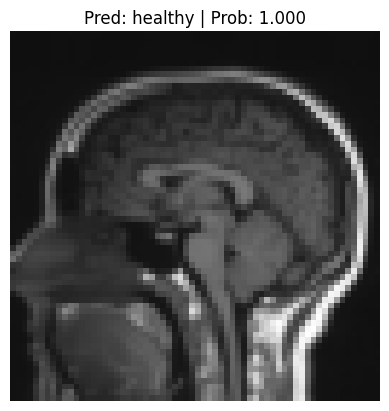

In [98]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=train_data.classes,
                    transform=custom_image_transform,
                    device=device)